# --- PASO 2:  DESCRIPCIÓN DE LA MUESTRA demogr4ficos ---
- Distribución de genero
- Distribución de posición politic4
- Distribución de nivel_se
- Distribución de punt4jes sdo
- Distribución de punt4jes ndc
- Distribución de expect4tiv4s

# --- PASO 3: ESTADÍSTICOS DESCRIPTIVOS b4sico ---
- Distribución de respuest4 por tr4t4miento (dist, Bloque_CON, Bloque_SIN)
- Distribución de respuest4 por blo#ue (Bloque_1, Bloque_3, Bloque_5, Bloque_7, Bloque_9, Bloque_11)
- Distribución de respuest4 por t4m4ño de g4p



# --- PASO 4: MODELOS  ---
- #ue v4ri4ble demogr4fic4 incide en l4 respuest4?
- 
- 

# --- PASO 0: C4RG4 DE D4TOS  ----
B4se de d4tos s4c4d4s de l4 unific4ción de los 12 fomrul4rios. 

### df_resultados_dict
L4 b4se de d4tos de los result4dos contiene l4s column4s:
- ID_sujeto (Suj_001...)
- origen_form (Respuestas de formulario 1...)
- identidad (ABC...)
- bloque (Bloque_1...)
- dilema (Bloque_CON...)
- categoria (1...)
- respuesta (Opción 2...)
contiene 21 fil4s por c4d4 sujeto

### df_demograficos_dict
L4 b4se de d4tos de los cuestion4rios contiene l4s column4s:
- ID_Sujeto (Suj_001...)
- Origen_Form (Respuestas de formulario 1...)
- expectativa_1, expectativa_2, expectativa_3 (pregunt4s de expect4tiv4)
- ndc_1, ndc_2,	ndc_3,	ndc_4,	ndc_5,	ndc_6 (need for cognition)
- sdo_1, sdo_2,	sdo_3,	sdo_4,	sdo_5,	sdo_6,	sdo_7, sdo_8, sdo_9, sdo_10 (soci4l domin4nce orient4tion)
- Genero 
- politica 
- nivel_se

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats


In [3]:
# 1. Cargar las bases de datos
df_res_dict = pd.read_csv('Base_res_dict.csv')
df_dem_dict = pd.read_csv('Base_Dem_dict.csv')
df_res_coop = pd.read_csv('Base_res_coop.csv')
df_info_bloques = pd.read_csv('Inform4ción blo#ues.csv')

# 2. Pre-procesamiento de Info Bloques para el merge
# Renombramos 'Nombre' a 'Bloque' para que coincida con df_res_dict
df_info_bloques = df_info_bloques.rename(columns={'Nombre': 'Bloque'})
# Seleccionamos variables de interés (Gap)
# Usamos 'Diferencia desigualdad final entre opciones' como el costo de revertir
cols_interes = ['Bloque', 'Diferencia desigualdad final entre opciones']
df_info_bloques_sel = df_info_bloques[cols_interes]

print("Datos cargados correctamente.")
print(f"Sujetos totales: {df_res_dict['ID_Sujeto'].nunique()}")

Datos cargados correctamente.
Sujetos totales: 162


## --- PASO 1: LIMPIEZA  ---
-Se elimin4n los sujetos #ue f4ll4ron l4s pregunt4s de 4tención (con f4ll4r 1 y4 se elimin4)
Recibe:
- df_demograficos_dict
- df_resultados_dict
162 sujetos

- df_resultados_coop
- df_demograficos_coop
46 sujetos


Devuelve:
- df_res_dict_clean
- df_demo_dict_clean
121 sujetos

- df_res_coop_clean
- df_demo_coop_clean
42 sujetos

In [4]:
# 1. Identificar fallos de atención
df_att = df_res_dict[df_res_dict['Bloque'] == 'Bloque_0']
failed_ids = df_att[df_att['Respuesta'] != 'Opción 3']['ID_Sujeto'].unique()

# 2. Filtrar Dataframes
df_res_clean = df_res_dict[~df_res_dict['ID_Sujeto'].isin(failed_ids)].copy()
df_dem_clean = df_dem_dict[~df_dem_dict['ID_Sujeto'].isin(failed_ids)].copy()
df_coop_clean = df_res_coop[~df_res_coop['ID_Sujeto'].isin(failed_ids)].copy()

# 3. Eliminar filas que no son de interés para el análisis (Bloque_0, Dilema 'Atencion')
df_res_clean = df_res_clean[df_res_clean['Bloque'] != 'Bloque_0']
df_res_clean = df_res_clean[df_res_clean['Dilema'] != 'Atencion']

print(f"Sujetos eliminados por atención: {len(failed_ids)}")
print(f"Muestra final limpia: {df_res_clean['ID_Sujeto'].nunique()}")


Sujetos eliminados por atención: 41
Muestra final limpia: 121


## --- PASO 2: C4mbio de v4ri4bles  ---
- Se cre4 l4 v4ri4ble "Reversion" (v4le 1 se responde opcion 2)
- Se c4mbi4 l4 v4ri4ble expect4tiv4 (v4le 1, 0, -1; h4y efecto positivo en opc1, no lo h4y, h4y efecto positivo en opc2)
- Se cre4 Scores Psicométricos (SDO y NDC)
- Se cre4 df_master (Unimos Resultados + Demográficos + Info Bloques )
- se cre4 column4 de expect4tiv4s_num (#ue respondió c4d4 sujeto en c4d4 g4p)
- se c4mbi4 nombre de column4
-     "Diferencia desigualdad final entre opciones" --> Gap_Size

In [ ]:
# ==============================================================================
# cre4ción de column4 expect4tiv4 4ctiv4
# ==============================================================================

def asignar_expectativa_segura(row):
    bloque = row['Bloque']
    
    # Bloques Sin Gap
    if bloque in ["Bloque_1", "Bloque_3"]:
        return row.get('expectativa_sin_num', np.nan)
        
    # Bloques Gap Grande
    elif bloque in ["Bloque_5", "Bloque_7"]:
        return row.get('expectativa_grande_num', np.nan)
        
    # Bloques Gap Pequeño
    elif bloque in ["Bloque_9", "Bloque_11"]:
        return row.get('expectativa_pequeña_num', np.nan)
        
    else:
        return np.nan

In [5]:
# 1. Codificar Variable Dependiente: REVERSIÓN DE RANKING
# Opción 2 = Revierte el ranking -> Codificamos como 1 (Reversión)
# Opción 1 = Mantiene el ranking -> Codificamos como 0 (Status Quo)
print("Conteo Original:")
print(df_res_clean['Respuesta'].value_counts())

df_res_clean['Reversion'] = df_res_clean['Respuesta'].apply(lambda x: 1 if x == 'Opción 2' else 0)

print("\nConteo Nueva Variable:")
print(df_res_clean['Reversion'].value_counts())

Conteo Original:
Opción 2    1357
Opción 1     821
Name: Respuesta, dtype: int64

Conteo Nueva Variable:
1    1357
0     821
Name: Reversion, dtype: int64


In [11]:
# 2. C4mbi4mos l4 sección de expect4tiv4s. Respuest4s y titulos p4r4 3ue se4 m4s sencillo
#respuest4s de expect4tiv4s. Definimos el diccionario con el mapeo exacto
mapeo_expectativas = {
    "No espero ningún efecto": 0,
    "La Opción 1 incrementa la probabilidad de cooperación": 1,
    "La opción 1 incrementa la posibilidad de cooperación" : 1,
    "La Opción 2 incrementa la probabilidad de cooperación": -1,
    "La opción 2 incrementa la posibilidad de cooperación": -1
}

cols_expectativas = ['expectativa_sin', 'expectativa_grande', 'expectativa_pequeña']

# Aplicamos el reemplazo
for col in cols_expectativas:
    if col in df_dem_clean.columns:
        df_dem_clean[col] = df_dem_clean[col].replace(mapeo_expectativas)

# CHE#UEO R4PIDO
#--------------------------------------------------------
## 1. list de column4s 4 prob4r
#cols_reales = ['expectativa_sin', 'expectativa_grande', 'expectativa_pequeña']

## 2. Verificamos columna por columna
#for col in cols_reales:
#    if col in df_dem_clean.columns:
#        valores = df_dem_clean[col].unique()
#        print(f"[{col}] Valores únicos: {valores}")
        
        # Alerta rápida si detecta texto
#        if df_dem_clean[col].dtype == 'object':
#             print(f"⚠️ ALERTA: La columna {col} todavía es texto. Revisa espacios o tildes.")
#    else:
#        print(f"❌ ERROR: No encuentro la columna '{col}'. Revisa si escribiste bien el nombre en la base de datos.")
#    print("-" * 30)
#-----------------------------------------------------------------

In [12]:
# 3. Calcular Scores Psicométricos (SDO y NDC)
sdo_cols = [c for c in df_dem_clean.columns if 'sdo_' in c]
ndc_cols = [c for c in df_dem_clean.columns if 'ndc_' in c]

# (Asumimos que no hay ítems reversos o que ya están invertidos. Promediamos).
df_dem_clean['SDO_Score'] = df_dem_clean[sdo_cols].mean(axis=1)
df_dem_clean['NDC_Score'] = df_dem_clean[ndc_cols].mean(axis=1)

In [23]:
# 4. Merge Final (Unir todo en un Master DataFrame)
# Unimos Resultados + Demográficos + Info Bloques 
cols_demograficas = [
    'ID_Sujeto', 
    'SDO_Score', 
    'NDC_Score',
    'expectativa_sin',    
    'expectativa_grande',   
    'expectativa_pequeña'  
]
df_master = df_res_clean.merge(df_dem_clean[cols_demograficas], on='ID_Sujeto', how='left')
df_master = df_master.merge(df_info_bloques_sel, on='Bloque', how='left')

In [24]:
#df_master.columns.tolist()

['ID_Sujeto',
 'Origen_Form',
 'Identidad',
 'Bloque',
 'Dilema',
 'Categoria',
 'Respuesta',
 'Reversion',
 'SDO_Score',
 'NDC_Score',
 'expectativa_sin',
 'expectativa_grande',
 'expectativa_pequeña',
 'Diferencia desigualdad final entre opciones']

In [26]:
# 5. Creo un4 column4 nuev4 sobre el df_m4ster
cols_exp = ['expectativa_sin', 'expectativa_grande', 'expectativa_pequeña']

for col in cols_exp:
    # Creamos las versiones numéricas: ej. 'expectativa_sin_num'
    if col in df_master.columns:
        df_master[f'{col}_num'] = df_master[col].fillna(0)

# Aplicamos la función
df_master['Expectativa_Activa'] = df_master.apply(asignar_expectativa_segura, axis=1)

In [27]:
#df_master.columns.tolist()

['ID_Sujeto',
 'Origen_Form',
 'Identidad',
 'Bloque',
 'Dilema',
 'Categoria',
 'Respuesta',
 'Reversion',
 'SDO_Score',
 'NDC_Score',
 'expectativa_sin',
 'expectativa_grande',
 'expectativa_pequeña',
 'Diferencia desigualdad final entre opciones',
 'expectativa_sin_num',
 'expectativa_grande_num',
 'expectativa_pequeña_num',
 'Expectativa_Activa']

In [28]:
# 6. Renombrar columna de Gap para facilitar uso
df_master.rename(columns={'Diferencia desigualdad final entre opciones': 'Gap_Size'}, inplace=True)


In [29]:
print("Variables creadas: Reversion, SDO_Score, NDC_Score, Gap_Size, Expectativa_Activa")
print(df_master[['ID_Sujeto', 'Bloque','Dilema', 'Reversion', 'Gap_Size', 'SDO_Score', 'Expectativa_Activa']].head())

Variables creadas: Reversion, SDO_Score, NDC_Score, Gap_Size, Expectativa_Activa
  ID_Sujeto    Bloque      Dilema  Reversion  Gap_Size  SDO_Score  \
0   Suj_001  Bloque_1  Bloque_CON          1         0        3.3   
1   Suj_001  Bloque_5  Bloque_CON          1      2000        3.3   
2   Suj_001  Bloque_7  Bloque_CON          1      2400        3.3   
3   Suj_001  Bloque_3  Bloque_CON          1         0        3.3   
4   Suj_001  Bloque_9  Bloque_CON          0      1000        3.3   

   Expectativa_Activa  
0                   0  
1                  -1  
2                  -1  
3                   0  
4                  -1  


C:\Users\felip\AppData\Local\Temp\ipykernel_9416\652039522.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=df_master, x='Dilema', y='Reversion', ci=95, palette="viridis", order=['Bloque_SIN', 'Bloque_CON', 'Dist'])
C:\Users\felip\AppData\Local\Temp\ipykernel_9416\652039522.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_master, x='Gap_Size', y='Reversion', hue='Dilema', ci=None, marker='o')


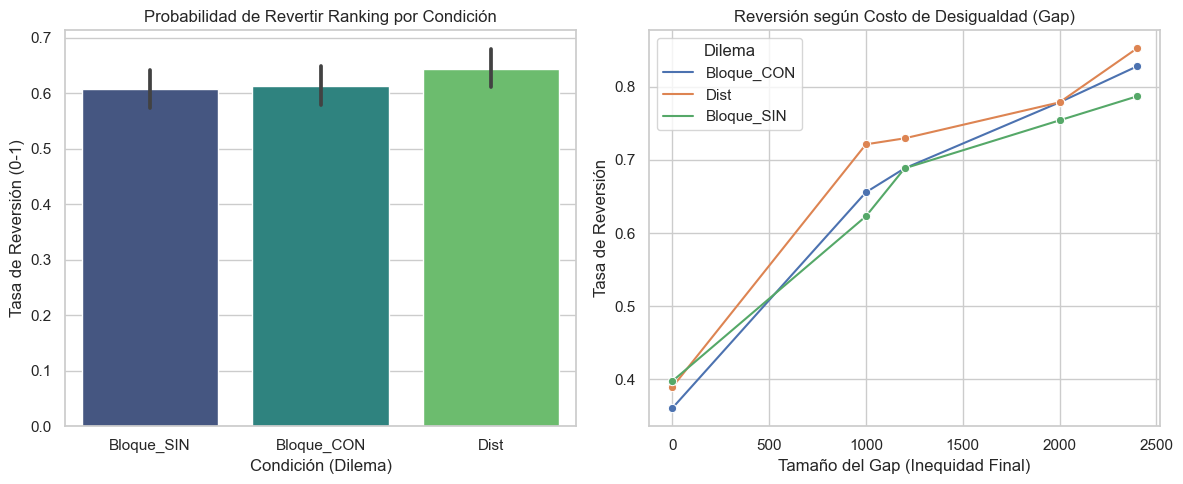


--- Tasas Medias de Reversión ---
Dilema
Bloque_CON    0.612022
Bloque_SIN    0.607923
Dist          0.643443
Name: Reversion, dtype: float64


In [30]:
# Configuración visual
sns.set(style="whitegrid")

plt.figure(figsize=(12, 5))

# Gráfico 1: Tasa de Reversión por Tratamiento
# Esto responde Q1: ¿La condición afecta la decisión?
plt.subplot(1, 2, 1)
sns.barplot(data=df_master, x='Dilema', y='Reversion', ci=95, palette="viridis", order=['Bloque_SIN', 'Bloque_CON', 'Dist'])
plt.title('Probabilidad de Revertir Ranking por Condición')
plt.ylabel('Tasa de Reversión (0-1)')
plt.xlabel('Condición (Dilema)')

# Gráfico 2: Efecto del Gap (Costo de Revertir)
# Esto responde si el costo monetario modera la decisión
plt.subplot(1, 2, 2)
sns.lineplot(data=df_master, x='Gap_Size', y='Reversion', hue='Dilema', ci=None, marker='o')
plt.title('Reversión según Costo de Desigualdad (Gap)')
plt.ylabel('Tasa de Reversión')
plt.xlabel('Tamaño del Gap (Inequidad Final)')

plt.tight_layout()
plt.show() # O usar plt.savefig('resultados_descriptivos.png')

# Tabla resumen numérica
print("\n--- Tasas Medias de Reversión ---")
print(df_master.groupby('Dilema')['Reversion'].mean())

In [31]:
# Modelo 1: Efecto Principal e Interacción con SDO (GLMM)

# Usamos GEE o GLM estándar con clusters por sujeto (ya que son medidas repetidas)
# Formula: Reversion ~ Dilema * SDO_Score
# (Usamos 'Bloque_SIN' como referencia para ver el cambio en 'Bloque_CON')

print("\n--- Modelo 1: Regresión Logística con Interacción SDO ---")
model = smf.logit("Reversion ~ C(Dilema, Treatment(reference='Bloque_SIN')) * SDO_Score + Gap_Size", data=df_master).fit()
print(model.summary())

# Interpretación rápida:
# - Si el coef de 'Dilema[T.Bloque_CON]' es significativo, hay efecto del tratamiento.
# - Si la interacción 'Dilema:SDO' es significativa, el SDO modera el efecto.


--- Modelo 1: Regresión Logística con Interacción SDO ---
Optimization terminated successfully.
         Current function value: 0.596154
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              Reversion   No. Observations:                 2196
Model:                          Logit   Df Residuals:                     2189
Method:                           MLE   Df Model:                            6
Date:                Tue, 20 Jan 2026   Pseudo R-squ.:                  0.1015
Time:                        14:54:17   Log-Likelihood:                -1309.2
converged:                       True   LL-Null:                       -1457.1
Covariance Type:            nonrobust   LLR p-value:                 6.425e-61
                                                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [33]:
# ==============================================================================
# OBJETIVO 1: Caracterización de la Muestra
# ==============================================================================
print("--- Tablas de Frecuencia ---")
cols_demograficas = ['Genero', 'nivel_se', 'politica']

for col in cols_demograficas:
    print(f"\nDistribución de {col}:")
    tabla = df_dem_clean[col].value_counts(normalize=True) * 100 # Porcentaje
    print(tabla.round(2).astype(str) + '%')

--- Tablas de Frecuencia ---

Distribución de Genero:
Mujer         66.39%
Hombre        31.15%
No binario     1.64%
Otro           0.82%
Name: Genero, dtype: object

Distribución de nivel_se:
6     27.05%
5     23.77%
7     16.39%
4     15.57%
3      6.56%
8      6.56%
2      1.64%
9      1.64%
10     0.82%
Name: nivel_se, dtype: object

Distribución de politica:
4    34.43%
2    17.21%
3    17.21%
5    15.57%
6     7.38%
1     5.74%
7     2.46%
Name: politica, dtype: object


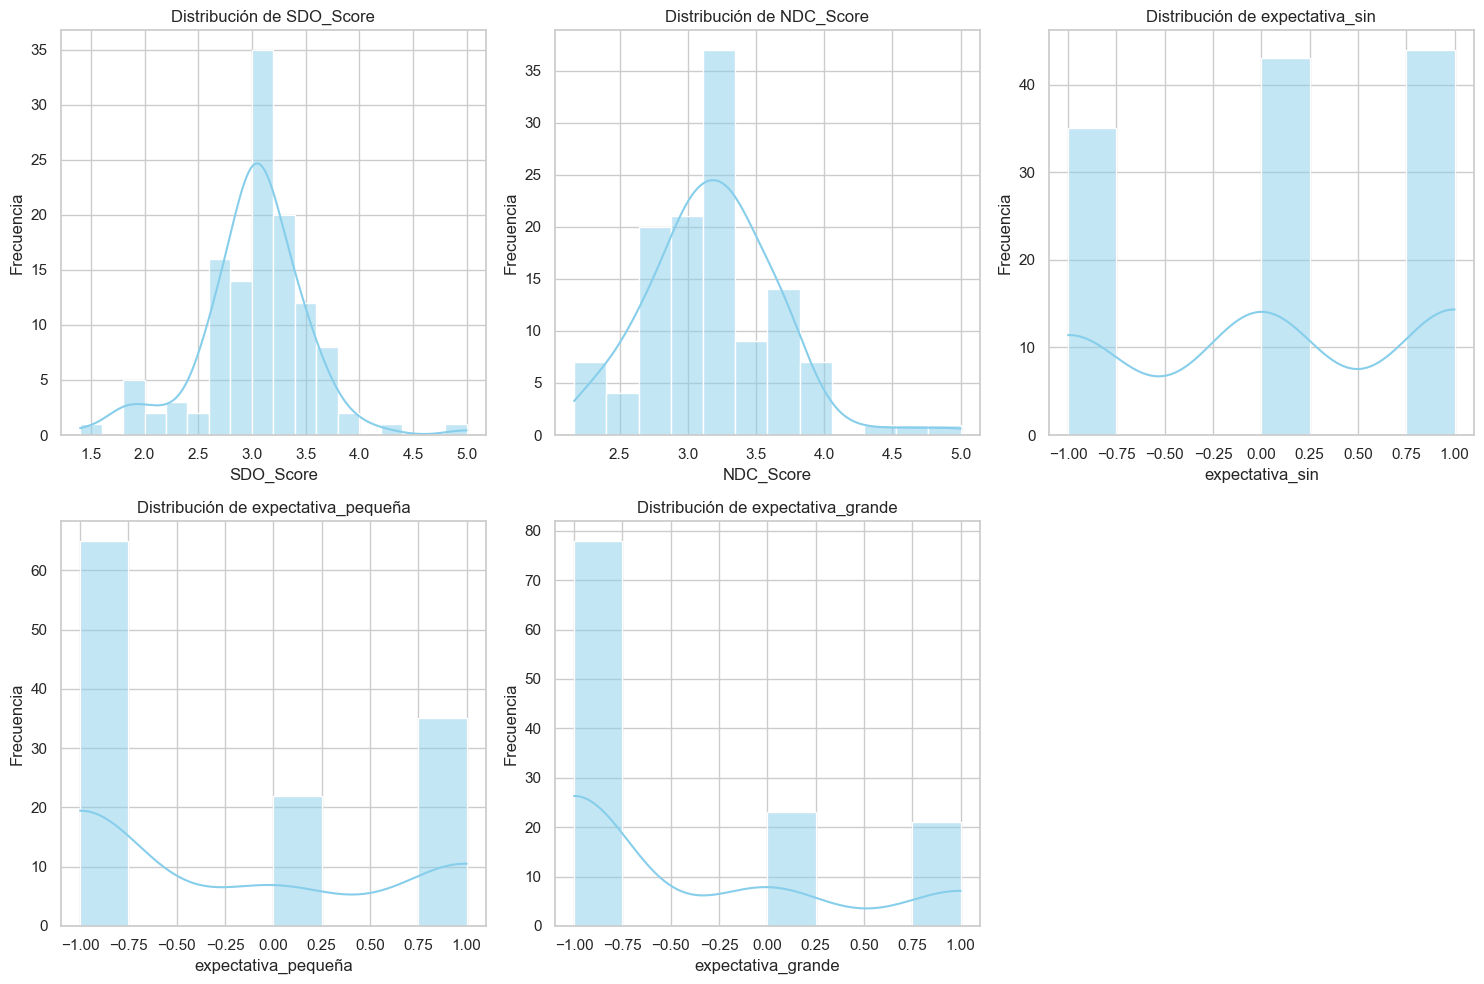

In [35]:
# ==============================================================================
# OBJETIVO 2: Distribución de Variables Clave (Histogramas)
# ==============================================================================

vars_clave = ['SDO_Score', 'NDC_Score', 'expectativa_sin', 'expectativa_pequeña', 'expectativa_grande']

# Aumentamos la altura de la figura a 10 para acomodar 2 filas
plt.figure(figsize=(15, 10))

for i, var in enumerate(vars_clave):
    plt.subplot(2, 3, i+1)
    
    sns.histplot(df_dem_clean[var], kde=True, color='skyblue')
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [36]:
# Definimos las listas separadas por tipo de variable
vars_categ = ['expectativa_sin', 'expectativa_pequeña', 'expectativa_grande']
vars_num = ['SDO_Score', 'NDC_Score']

print("==========================================")
print(" TABLAS DE FRECUENCIA (Variables Categóricas)")
print("==========================================\n")

for var in vars_categ:
    if var in df_dem_clean.columns:
        print(f"--- Distribución de: {var} ---")
        # Calculamos frecuencia (n) y porcentaje (%)
        conteo = df_dem_clean[var].value_counts()
        porcentaje = df_dem_clean[var].value_counts(normalize=True) * 100
        
        # Unimos ambas en una tabla bonita
        tabla = pd.concat([conteo, porcentaje.round(1)], axis=1)
        tabla.columns = ['n', '%']
        print(tabla)
        print("-" * 30 + "\n")

print("\n==========================================")
print(" ESTADÍSTICOS DESCRIPTIVOS (Variables Numéricas)")
print("==========================================\n")

# Para SDO y NDC usamos describe() para obtener Media, Desviación, Mín y Máx
desc_stats = df_dem_clean[vars_num].describe().round(2)

# Seleccionamos solo las filas relevantes para el paper
filas_importantes = ['count', 'mean', 'std', 'min', 'max']
print(desc_stats.loc[filas_importantes])

 TABLAS DE FRECUENCIA (Variables Categóricas)

--- Distribución de: expectativa_sin ---
     n     %
 1  44  36.1
 0  43  35.2
-1  35  28.7
------------------------------

--- Distribución de: expectativa_pequeña ---
     n     %
-1  65  53.3
 1  35  28.7
 0  22  18.0
------------------------------

--- Distribución de: expectativa_grande ---
     n     %
-1  78  63.9
 0  23  18.9
 1  21  17.2
------------------------------


 ESTADÍSTICOS DESCRIPTIVOS (Variables Numéricas)

       SDO_Score  NDC_Score
count     122.00     122.00
mean        3.01       3.19
std         0.50       0.47
min         1.40       2.17
max         5.00       5.00


In [40]:
df_master.columns.tolist()

['ID_Sujeto',
 'Origen_Form',
 'Identidad',
 'Bloque',
 'Dilema',
 'Categoria',
 'Respuesta',
 'Reversion',
 'SDO_Score',
 'NDC_Score',
 'expectativa_sin',
 'expectativa_grande',
 'expectativa_pequeña',
 'Gap_Size',
 'expectativa_sin_num',
 'expectativa_grande_num',
 'expectativa_pequeña_num',
 'Expectativa_Activa']


=== MODELO 2: Sensibilidad al Costo ===
Optimization terminated successfully.
         Current function value: 0.598480
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              Reversion   No. Observations:                 2196
Model:                          Logit   Df Residuals:                     2190
Method:                           MLE   Df Model:                            5
Date:                Tue, 20 Jan 2026   Pseudo R-squ.:                 0.09801
Time:                        15:13:16   Log-Likelihood:                -1314.3
converged:                       True   LL-Null:                       -1457.1
Covariance Type:            nonrobust   LLR p-value:                 1.243e-59
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept              

<Figure size 800x600 with 0 Axes>

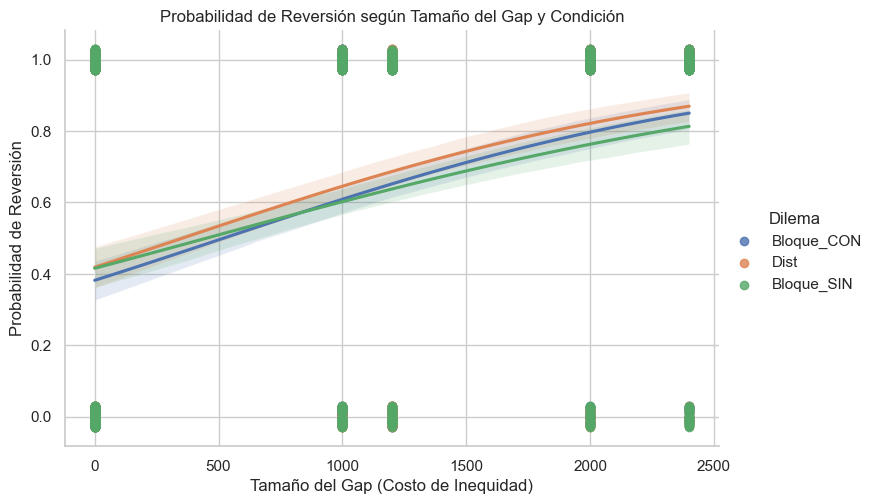

In [42]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# ==============================================================================
# MODELO 2: Análisis de Sensibilidad al Costo (Gap)
# Acción: Regresión logística (Probabilidad Reversión ~ Gap_Size * Condicion)
# ==============================================================================

print("\n=== MODELO 2: Sensibilidad al Costo ===")

# Opción A: Regresión Logística Estadística
# Usamos 'Gap_Size * Condicion' para ver la interacción
model_2 = smf.logit("Reversion ~ Gap_Size * C(Dilema)", data=df_master).fit()
print(model_2.summary())

# Opción B: Gráfico de Curvas (Probabilidad de Reversión)
plt.figure(figsize=(8, 6))
sns.lmplot(
    x="Gap_Size", 
    y="Reversion", 
    hue="Dilema", 
    data=df_master, 
    logistic=True,  # Esto ajusta la curva sigmoide
    y_jitter=0.03,  # Pequeño ruido visual para ver los puntos mejor
    aspect=1.5
)
plt.title("Probabilidad de Reversión según Tamaño del Gap y Condición")
plt.ylabel("Probabilidad de Reversión")
plt.xlabel("Tamaño del Gap (Costo de Inequidad)")
plt.show()
